In [866]:
import cv2
import pytesseract
import numpy as np
import imutils
import pyocr
import pyocr.builders
import re

from PIL import Image
from scipy.spatial import distance
from matplotlib import pyplot as plt

origin: (790, 634, 3)


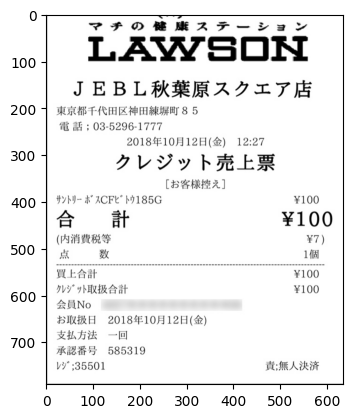

In [867]:
image = cv2.imread('./examples/invoice_sample7.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img = image.copy()
# img = imutils.resize(img, height=500)

print('origin:', image.shape)
plt.imshow(img)

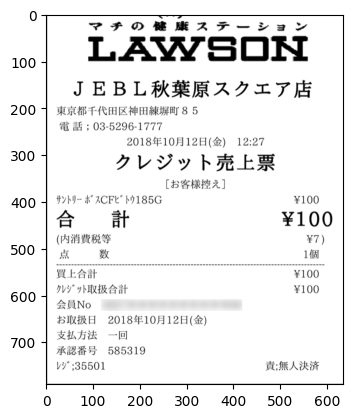

In [868]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

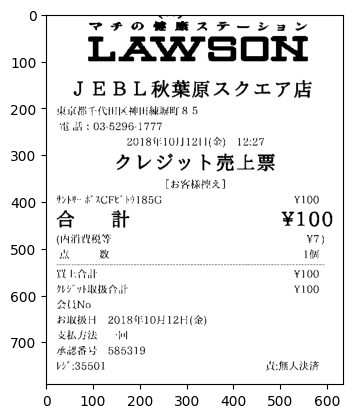

In [869]:
_, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
plt.imshow(otsu, cmap='gray')

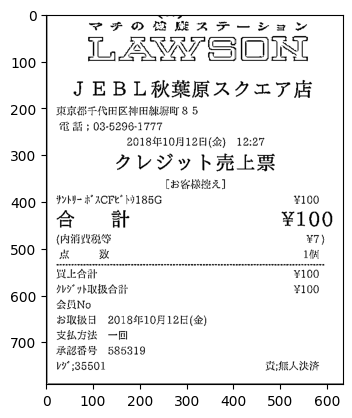

In [870]:
adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize=9, C=20)
plt.imshow(adaptive, cmap='gray')

Observer from above result, we will use "adaptiveThreshold" to adjust lighting issue.

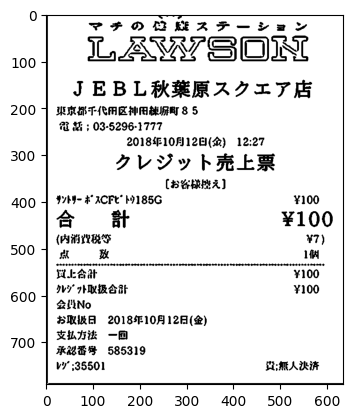

In [871]:
thresh_img = adaptive.copy()
thresh_img = cv2.blur(thresh_img, (3,3))
# thresh_img = cv2.dilate(thresh_img, (3,3), iterations=2)
# thresh_img = cv2.erode(thresh_img, (3,3), iterations=1)
thresh_img = cv2.threshold(thresh_img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)[1]
plt.imshow(thresh_img, cmap='gray')

# draw bounding box from box

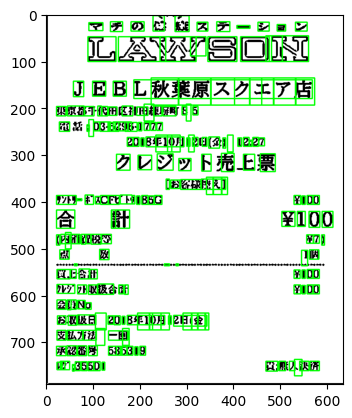

In [872]:
img = thresh_img.copy()
draw_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
config = r'--oem 3 --psm 6'

h,w = img.shape
boxes = pytesseract.image_to_boxes(img, lang='jpn_best+eng', config=config)
for b in boxes.splitlines():
    b = b.split(' ')
    p1 = (int(b[1]), h-int(b[2]))
    p2 = (int(b[3]), h-int(b[4]))
    cv2.rectangle(draw_img, p1, p2, (0,255,0), 2)

plt.imshow(draw_img)

# template pattern matching


03-.52961777
¥100
¥100
¥7)
¥100


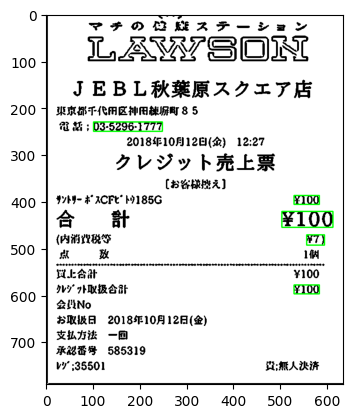

In [874]:
date_pattern = r'(\d{1,4}( ?)+(\年|\月|\日|\-|\/))+(\D)+(\d{1,2}:\d{1,2})?'
money_pattern = r'(\$|\¥)+\d+(?:(\.|\,)\d+)?'
img = thresh_img.copy()
draw_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

result = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT, lang='jpn_best+eng', config=config)
n_boxes = len(result['text'])
for i in range(n_boxes):
    if re.search(date_pattern, result['text'][i]) or re.search(money_pattern, result['text'][i]):
        x,y,w,h = result['left'][i], result['top'][i], result['width'][i], result['height'][i]
        p1 = (x,y)
        p2 = (x+w, y+h)
        cv2.rectangle(draw_img, p1, p2, (0,255,0), 2)
        print(result['text'][i])
            
plt.imshow(draw_img)

After a few experiments, I found that the Japanese Kanji recognition does not perform well as I expected.

In the above examples, I tried to extract the receipt date time, and the total cost.  it returns the wrong date and time translation in Kanji. I thought it related to Japanese OCR model accuracy.